In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2 as cv
import cv2
import cv2.cuda

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import csv
import sys
import os

In [6]:
sys.path.append('/kaggle/input/source')
import preprocess

In [7]:
# import dlib

# class LandMark():
#     def __init__(self, img):
#         self.img = img
        
#     def extract(self):
#         detector = dlib.get_frontal_face_detector()
#         dets = detector(self.img, 0)  # 使用detector进行人脸检测 dets为返回的结果
        
#         predictor_path = "/kaggle/input/facemodel/shape_predictor_68_face_landmarks.dat"
#         predictor = dlib.shape_predictor(predictor_path)
#         shape_list = []
#         landmark = []
#         for index, face in enumerate(dets):
#             shape = predictor(self.img, face)  # 寻找人脸的68个标定点
#             # 遍历所有点，打印出其坐标，并用绿色的圈表示出来
#             for _, pt in enumerate(shape.parts()):
#                 pt_pos = (pt.x, pt.y)
#                 landmark.append(pt_pos)
#                 cv.circle(self.img, pt_pos, 1, (0, 255, 0), 1)
#             shape_list.append(shape)
#         landmark = np.array(landmark)
#         new_img = self.img[landmark[:, 0], landmark[:, 1]]
#         new_img = np.array(new_img)
#         return new_img
        
        

In [8]:
maxInt = sys.maxsize
decrement = True
 
while decrement:
    # decrease the maxInt value by factor 10
    # as long as the OverflowError occurs.
 
    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt / 10)
        decrement = True

In [9]:
def resize_picture(image):
    crop_left = 0  # Start x-coordinate for cropping
    crop_top = 0   # Start y-coordinate for cropping
    crop_width = 224  # Width of the crop
    crop_height = 224 # Height of the crop

# Crop the image
    cropped_image = image[crop_top:crop_top + crop_height, crop_left:crop_left + crop_width]

# Resize the cropped image to (256, 256)
    resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_LINEAR)
    return resized_image

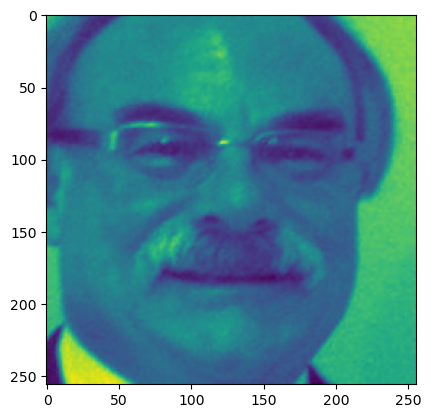

In [10]:
image = cv2.imread('/kaggle/input/affectnet/train_set/train_set/images/0.jpg', cv2.IMREAD_GRAYSCALE)
image = resize_picture(image)
plt.imshow(image)

In [11]:
import torch
import numpy as np
import cv2
import math

class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 // self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

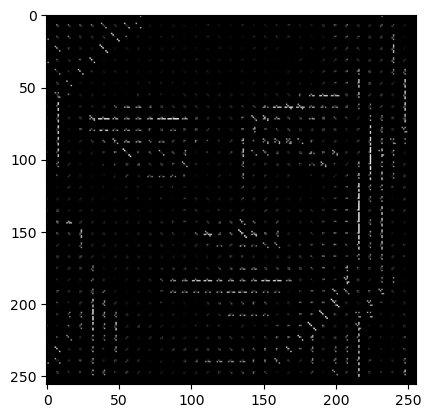

In [12]:
img = cv2.imread('/kaggle/input/affectnet/train_set/train_set/images/10.jpg', cv2.IMREAD_GRAYSCALE)
img = resize_picture(img)
hog = Hog_descriptor(img, cell_size=8, bin_size=8)
vector, image = hog.extract()
cv.imwrite(os.path.join('/kaggle/working/', 'hogpic.jpg'), image)
plt.imshow(image, cmap=plt.cm.gray)

In [13]:
# print(cv2.cuda.getCudaEnabledDeviceCount())

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets

class HOGLayer(nn.Module):
    def __init__(self, cell_size, block_size, num_bins):
        super(HOGLayer, self).__init__()
        self.cell_size = cell_size
        self.block_size = block_size
        self.num_bins = num_bins
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        self.sobel_filter_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device = device)
        self.sobel_filter_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device = device)

    def forward(self, x):
        batch_size, height, width = x.size()
        x = x.float()
        # Calculate gradients using Sobel filters
        gradients_x = F.conv2d(x, self.sobel_filter_x.unsqueeze(0).unsqueeze(0))
        gradients_y = F.conv2d(x, self.sobel_filter_y.unsqueeze(0).unsqueeze(0))

        # Calculate gradient magnitudes and angles
        gradient_magnitudes = torch.sqrt(gradients_x ** 2 + gradients_y ** 2)
        gradient_angles = torch.atan2(gradients_y, gradients_x)

        # Calculate HOG features
        hog_features = []
        for i in range(batch_size):
            hog_feature = self.compute_hog_features(gradient_magnitudes[i], gradient_angles[i])
            hog_features.append(hog_feature)

        hog_features = torch.stack(hog_features)
        return hog_features

    def compute_hog_features(self, gradient_magnitudes, gradient_angles):
        # Compute histograms for cells
        num_cells_x = gradient_magnitudes.size(0) // self.cell_size
        num_cells_y = gradient_magnitudes.size(1) // self.cell_size
        histograms = torch.zeros(num_cells_x, num_cells_y, self.num_bins, device = self.device)
#         print('gradient_magnitude', gradient_magnitudes.device)
#         print('histograms', histograms.device)

        for i in range(num_cells_x):
            for j in range(num_cells_y):
                cell_magnitudes = gradient_magnitudes[i * self.cell_size:(i + 1) * self.cell_size,
                                                      j * self.cell_size:(j + 1) * self.cell_size]
                cell_angles = gradient_angles[i * self.cell_size:(i + 1) * self.cell_size,
                                              j * self.cell_size:(j + 1) * self.cell_size]
                histograms[i, j] = self.compute_cell_histogram(cell_magnitudes, cell_angles)

        # Block normalization
        hog_features = []
        for i in range(num_cells_x - self.block_size + 1):
            for j in range(num_cells_y - self.block_size + 1):
                block_histograms = histograms[i:i + self.block_size, j:j + self.block_size]
                block_histograms = block_histograms.reshape(-1)
                block_histograms /= torch.norm(block_histograms) + 1e-5  # L2 normalization
                hog_features.append(block_histograms)

        return torch.cat(hog_features)

    def compute_cell_histogram(self, cell_magnitudes, cell_angles):
        histogram = torch.zeros(self.num_bins, device = self.device)
#         print(cell_angles.device)

        angle_unit = 360 / self.num_bins
        for i in range(cell_magnitudes.size(0)):
            for j in range(cell_magnitudes.size(1)):
                magnitude = cell_magnitudes[i, j]
                angle = cell_angles[i, j]
                min_angle, max_angle, mod = self.get_closest_bins(angle)
                histogram[min_angle] += (magnitude * (1 - (mod / angle_unit)))
                histogram[max_angle] += (magnitude * (mod / angle_unit))

        return histogram

    def get_closest_bins(self, angle):
        idx = int(angle / (360 / self.num_bins))
        mod = angle % (360 / self.num_bins)
        if idx == self.num_bins:
            return idx - 1, (idx) % self.num_bins, mod
        return idx, (idx + 1) % self.num_bins, mod

In [15]:
def extract_features_byhog(img_path, cell_size=8, block_size=2, num_bins=8):
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using device:", device)

# Create the HOG layer
    hog_layer = HOGLayer(cell_size, block_size, num_bins)

    hog_layer.to(device)
# print(hog_layer.device)

# Example usage
#     transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
# dataset = datasets.ImageFolder("/kaggle/input/subtrainset2", transform=transform)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = resize_picture(img)
    image = torch.tensor(img)

# image, _ = dataset[0]  # Get an example image
    image = image.unsqueeze(0)  # Add batch dimension

# print(image.shape)

# image_tensor = data_transform(image).unsqueeze(0)  # Add batch dimension

    image = image.to(device)
#     print(image.device)

    hog_features = hog_layer(image)
    
    return hog_features.cpu().numpy()


In [16]:
# Define HOG parameters
cell_size = 8
block_size = 2
num_bins = 8

hog_features = extract_features_byhog('/kaggle/input/subtrainset2/images/1.jpg')
print("HOG Features shape:", hog_features.shape)

HOG Features shape: (1, 28800)


In [17]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(vector)

# # Calculate the required number of principal components to retain the desired variance
# desired_variance_ratio = 0.9  # Choose the desired amount of variance to retain
# pca = PCA(n_components=desired_variance_ratio)
# X_pca = pca.fit_transform(X_scaled)
# X_pca.shape


In [18]:
# class CustomImageDataset(Dataset):
#     def __init__(self, data_dir, transform=None, test=False):
#         self.data_dir = data_dir
#         self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         image_path = os.path.join(self.data_dir, self.image_files[idx])
#         image = Image.open(image_path).convert('L')  # Convert to grayscale

#         if self.transform:
#             image = self.transform(image)

In [19]:
def create_gabor_filter(kernel_size, sigma, theta, frequency, psi, gamma):
    """
    Create a Gabor filter kernel.

    Args:
        kernel_size (int): Size of the kernel.
        sigma (float): Standard deviation of the Gaussian envelope.
        theta (float): Orientation of the Gabor filter in radians.
        frequency (float): Frequency of the sinusoidal function.
        psi (float): Phase offset.
        gamma (float): Aspect ratio.

    Returns:
        Gabor filter kernel (torch.Tensor).
    """
    half_size = kernel_size // 2
    y, x = np.meshgrid(np.arange(-half_size, half_size + 1), np.arange(-half_size, half_size + 1))

    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gabor = np.exp(-(x_theta**2 + gamma**2 * y_theta**2) / (2 * sigma**2)) * np.cos(2 * np.pi * frequency * x_theta + psi)

    gabor_tensor = torch.tensor(gabor, dtype=torch.float32)
    return gabor_tensor / torch.sum(gabor_tensor)  # Normalize the kernel


In [20]:
class GaborFilter(nn.Module):
    def __init__(self, kernel_size, sigma, theta, frequency, psi, gamma):
        super(GaborFilter, self).__init__()
        self.kernel = create_gabor_filter(kernel_size, sigma, theta, frequency, psi, gamma)
        self.kernel = self.kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    def forward(self, x):
        return F.conv2d(x, self.kernel, padding=self.kernel.size(2) // 2)


In [21]:
def extract_features(image_path, gabor_filter, pca_components=64, cell_size=(8, 8), block_size=(2, 2)):
#     image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = cv.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = preprocess.gray_norm(image)
    image = preprocess.adaptive_histogram_equalization(image)
    data_transform = transforms.Compose([
#         transforms.Resize((256, 256)),  # Resize the image to a fixed size
        transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    ])
    image_tensor = data_transform(image).unsqueeze(0)  # Add batch dimension
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using device:", device)
    image_tensor.to(device)

    # Apply Gabor filters
#     gabor_filter = GaborFilter(kernel_size=15, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)
    gabor_filter.to(device)  # Move Gabor filter model to GPU
    
    gabor_features = gabor_filter(image_tensor)

    # Convert Gabor features to numpy array
    gabor_features = gabor_features.squeeze().detach().numpy()
#     gabor_features = gabor_features.reshape(1, -1)

    # Apply HOG
#     hog_features, _ = hog(gabor_features, pixels_per_cell=cell_size, cells_per_block=block_size, visualize=True)

    # Apply PCA for dimensionality reduction
#     pca = PCA(n_components=pca_components)
    hog_features = StandardScaler().fit_transform(gabor_features)
#     hog_features = pca.fit_transform(hog_features)

    return hog_features

In [22]:
def extract_features_forcsv(image, gabor_filter, pca_components=64, cell_size=(8, 8), block_size=(2, 2)):
#     image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = preprocess.gray_norm(image)
    image = preprocess.adaptive_histogram_equalization(image)
    data_transform = transforms.Compose([
#         transforms.Resize((256, 256)),  # Resize the image to a fixed size
        transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    ])
    image_tensor = data_transform(image).unsqueeze(0)  # Add batch dimension
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using device:", device)
    image_tensor.to(device)

    # Apply Gabor filters
#     gabor_filter = GaborFilter(kernel_size=15, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)
    gabor_filter.to(device)  # Move Gabor filter model to GPU
    
    gabor_features = gabor_filter(image_tensor)

    # Convert Gabor features to numpy array
    gabor_features = gabor_features.squeeze().detach().numpy()
#     gabor_features = gabor_features.reshape(-1, 1)

    # Apply HOG
#     hog_features, _ = hog(gabor_features, pixels_per_cell=cell_size, cells_per_block=block_size, visualize=True)

    # Apply PCA for dimensionality reduction
#     pca = PCA(n_components=pca_components)
    hog_features = StandardScaler().fit_transform(gabor_features)
#     hog_features = pca.fit_transform(hog_features)

    return hog_features

In [23]:
output_folder = '/kaggle/working/val_set'
os.makedirs(output_folder, exist_ok=True)

output_folder = '/kaggle/working/subtrain_set'
os.makedirs(output_folder, exist_ok=True)


In [24]:
# data_dir = '/kaggle/input/affectnet/val_set/val_set/images'
# image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]

# gabor_filter = GaborFilter(kernel_size=15, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)

# for image_file in image_files:
#     image_path = os.path.join(data_dir, image_file)
#     features = extract_features(image_path, gabor_filter)
#     print(f"Extracted features for {image_file}: {features.shape}")
    
#     output_file = os.path.join(output_dir, f"features_{i+1}.csv")
#     with open(output_file, 'w', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(features)

In [25]:
def load_images_from_directory(directory, index):
#     np.set_printoptions(threshold=sys.maxsize)
    images = []
    labels = []
    indexes = []
    nums = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    annotation_directory = os.path.join(directory, 'annotations'+str(index))
    image_directory = os.path.join(directory, 'images'+str(index))
    image_list = os.listdir(image_directory)
#     gabor_filter = GaborFilter(kernel_size=5, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)
    # for filename in os.listdir(image_directory):
    for i in tqdm(range(len(image_list))):
        if image_list[i].endswith('.jpg') or image_list[i].endswith('.png') or image_list[i].endswith('.jpeg'):
            img_path = os.path.join(image_directory, image_list[i])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             lnd = LandMark(img)
#             img = resize_picture(img)
#             hog = Hog_descriptor(img, cell_size=8, bin_size=8)
#             features = extract_features_byhog(img_path)
#             features = hog.extract().flatten()
            index = image_list[i].split('.')[0]
            exp_file = os.path.join(annotation_directory, index + '_exp.npy')
            exp = np.load(exp_file).astype('int')
            lnd_file = os.path.join(annotation_directory, index + '_lnd.npy')
            lnd = np.load(lnd_file)
            maxs = np.round(lnd).astype('int')
            maxs = np.clip(maxs, 0, 223)
            maxs = maxs.reshape(-1, 2)
            features = img[maxs[:, 0], maxs[:, 1]]
            nums[exp] += 1
            index = int(index)
            images.append(features)
            labels.append(exp)
            indexes.append(index)
    images = np.array(images)
    labels = np.array(labels)
    indexes = np.array(indexes)
    
    return images, labels, indexes
#             output_file = os.path.join(output_folder, index+'.csv')
#             with open(output_file, 'w', newline='') as csvfile:
#                 fieldnames = ['name', 'image', 'label']
#                 writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#                 writer.writeheader()
#                 flattened_img = features.flatten()
#                 writer.writerow({'name': index, 'image': flattened_img, 'label': exp})


In [26]:
def load_images_from_directory_forcsv(directory, output_folder):
    np.set_printoptions(threshold=sys.maxsize)
    images = []
    labels = []
    indexes = []
    nums = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    expressions = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt',
                            'None', 'Uncertain', 'No-face']
    for i in tqdm(range(len(expressions))):
        if expressions[i] == 'None' or expressions[i] == 'No-face':
            continue
        expression_folder = os.path.join(directory, expressions[i])
#     annotation_directory = os.path.join(directory, 'annotations')
#     image_directory = os.path.join(directory, 'images')
        image_list = os.listdir(expression_folder)
        nums[i] = len(image_list)
        gabor_filter = GaborFilter(kernel_size=5, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)
    # for filename in os.listdir(image_directory):
        for i in tqdm(range(len(image_list))):
            file_name = os.path.join(expression_folder, image_list[i])
            with open(file_name, 'r') as csv_file:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    name = row['name']
                    index = int(name)
                    x_list = row['image'][1:-1].split()
                    flattened_image = [int(x) for x in x_list]
                    img = np.array(flattened_image).reshape(224, 224).astype('uint8')
                    features = extract_features_forcsv(img, gabor_filter, pca_components=120).flatten()
                    label = row['label']
                    label = int(label)
                    images.append(features.faltten())
                    labels.appendapp(label)
                    index.append(name)
                    
    images = np.array(images)
    labels = np.array(labels)
    indexes = np.array(indexes)
    
    return images, labels, indexes
                    
#                 output_file = os.path.join(output_folder, index+'.csv')
#                 with open(output_file, 'w', newline='') as csvfile:
#                     fieldnames = ['name', 'image', 'label']
#                     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#                     writer.writeheader()
#                     flattened_img = features.flatten()
#                     writer.writerow({'name': index, 'image': flattened_img, 'label': exp})

In [27]:
# images, labels, names = load_images_from_directory('/kaggle/input/subtrainset7', 0)
# load_images_from_directory_forcsv('/kaggle/input/subtrainset', '/kaggle/working/subtrain_set')


# desired_variance_ratio = 0.95
# pca = PCA(n_components=desired_variance_ratio)

# hog_features = pca.fit_transform(images)


In [28]:
import pickle


for i in range(51):
    images, labels, names = load_images_from_directory('/kaggle/input/subtrainset9', i)

    with open(os.path.join('/kaggle/working/subtrain_set', 'subtrain'+str(i)+'.pkl'), 'wb') as f:
        pickle.dump(images, f)
        pickle.dump(labels, f)

100%|██████████| 2652/2652 [00:44<00:00, 59.19it/s]


In [29]:
# images, labels, names = load_images_from_directory('/kaggle/input/affectnet/val_set/val_set')

# with open(os.path.join('/kaggle/working/subtrain_set', 'testset.pkl'), 'wb') as f:
#     pickle.dump(images, f)
#     pickle.dump(labels, f)

In [30]:
# for i in len(labels):
#     output_file = os.path.join('/kaggle/working/val_set2', str(names[i])+'.csv')
#     with open(output_file, 'w', newline='') as csvfile:
#         fieldnames = ['name', 'image', 'label']
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#         writer.writeheader()
#         flattened_img = hog_features[i].flatten()
#         writer.writerow({'name': names[i], 'image': flattened_img, 'label': labels[i]})

In [31]:
# images2, labels2, names2 = load_images_from_directory_forcsv('/kaggle/input/subtrainset')
# # load_images_from_directory_forcsv('/kaggle/input/subtrainset', '/kaggle/working/subtrain_set')

# pca = PCA(n_components=6697)

# hog_features = pca.fit_transform(images2)


In [32]:
# for i in len(labels2):
#     output_file = os.path.join('/kaggle/working/subtrain_set', str(names[i])+'.csv')
#     with open(output_file, 'w', newline='') as csvfile:
#         fieldnames = ['name', 'image', 'label']
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#         writer.writeheader()
#         flattened_img = hog_features2[i].flatten()
#         writer.writerow({'name': names2[i], 'image': flattened_img, 'label': labels2[i]})

In [33]:
# gabor_filter = GaborFilter(kernel_size=15, sigma=2, theta=np.pi/4, frequency=0.2, psi=0, gamma=1)
# with open('/kaggle/input/subtrainset/Contempt/100012.csv', 'r') as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         name = row['name']
                    
#         x_list = row['image'][1:-1].split()
#         flattened_image = [int(x) for x in x_list]
#         img = np.array(flattened_image).reshape(224, 224).astype('uint8')
#         features = extract_features_forcsv(img, gabor_filter, pca_components=120)
#         label = row['label']
        
#         print(features)
#         print(name)
#         print(label)


In [34]:
# features.shape
# plt.imshow(features)

In [35]:
# image = cv.imread('/kaggle/input/affectnet/val_set/val_set/images/10.jpg', cv2.IMREAD_GRAYSCALE)
# data_transform = transforms.Compose([
# #         transforms.Resize((256, 256)),  # Resize the image to a fixed size
#         transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
#     ])
# image = data_transform(image)
# image.shape